In [1]:
import pandas as pd
import glob
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

## Getting the map of davidson county

In [16]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

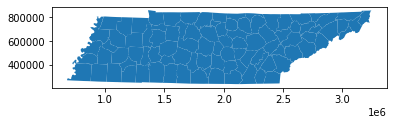

In [17]:
gdf_county.plot()

In [18]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [19]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [20]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Reading and parsing all accident files over Nashville

In [9]:

files = glob.glob('./waze_tn_alerts/city=Nashville/year=*/month=*/*.parquet')
agg_df = []
for fp in files:
    read_df = pd.read_parquet(fp, columns =['ts', 'geo', 'type'])
    read_df = read_df['ACCIDENT' == read_df['type']]
    agg_df.append(read_df)
df = pd.concat(agg_df)

df = df.sort_values('ts')
df['datetime'] = df['ts']
df['dt_UTC'] = df['ts']
for i, row in df.iterrows():
    df.loc[i, 'dt'] = pd.to_datetime(row['datetime'][:-4])
#     df.loc[i, 'dt'] = df.loc[i, 'dt'].tz_localize('UTC').tz_convert('US/Pacific')
df['dt']=df['dt'].dt.tz_localize('UTC').dt.tz_convert('US/Central')

df['ts_cst'] = df[['dt']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df = df.reset_index()
rdf = gpd.GeoDataFrame( df )

,index,ts,geo,type,datetime,dt_UTC,dt,ts_cst
0,8751,2019-04-22 12:06:58 UTC,POINT(-86.80638 36.170188),ACCIDENT,2019-04-22 12:06:58 UTC,2019-04-22 12:06:58 UTC,2019-04-22 07:06:58-05:00,1555934818
1,3266,2019-04-22 12:08:55 UTC,POINT(-86.776219 36.208805),ACCIDENT,2019-04-22 12:08:55 UTC,2019-04-22 12:08:55 UTC,2021-11-15 10:15:27-06:00,1636992927
2,6521,2019-04-22 12:09:15 UTC,POINT(-86.776231 36.208708),ACCIDENT,2019-04-22 12:09:15 UTC,2019-04-22 12:09:15 UTC,2020-10-20 05:33:45-05:00,1603190025
3,9873,2019-04-22 12:18:58 UTC,POINT(-86.856853 36.321678),ACCIDENT,2019-04-22 12:18:58 UTC,2019-04-22 12:18:58 UTC,2019-09-06 13:28:55-05:00,1567794535
4,4360,2019-04-22 12:28:42 UTC,POINT(-86.769845 36.109318),ACCIDENT,2019-04-22 12:28:42 UTC,2019-04-22 12:28:42 UTC,2020-11-18 08:25:07-06:00,1605709507
...,...,...,...,...,...,...,...,...
53997,7595,2022-03-06 21:57:19 UTC,POINT(-86.72804 36.109408),ACCIDENT,2022-03-06 21:57:19 UTC,2022-03-06 21:57:19 UTC,2022-03-06 15:57:19-06:00,1646603839
53998,5638,2022-03-06 22:03:01 UTC,POINT(-86.764631 36.166673),ACCIDENT,2022-03-06 22:03:01 UTC,2022-03-06 22:03:01 UTC,2022-03-06 16:03:01-06:00,1646604181
53999,19134,2022-03-06 22:13:03 UTC,POINT(-86.690228 36.303853),ACCIDENT,2022-03-06 22:13:03 UTC,2022-03-06 22:13:03 UTC,2022-03-06 16:13:03-06:00,1646604783
54000,13278,2022-03-06 22:19:52 UTC,POINT(-86.758768 36.232374),ACCIDENT,2022-03-06 22:19:52 UTC,2022-03-06 22:19:52 UTC,2022-03-06 16:19:52-06:00,1646605192


In [10]:
for i, row in rdf.iterrows():
    rdf.loc[i, 'lon'] = rdf.iloc[i].geo.split('(')[1].split(' ')[0]
    rdf.loc[i, 'lat'] = rdf.iloc[i].geo.split(' ')[1][:-1]

In [48]:
# converting to geopandas
rdf2 = gpd.GeoDataFrame(rdf, geometry=gpd.points_from_xy(rdf.lon, rdf.lat))
rdf2 = rdf2[['ts_cst', 'dt','dt_UTC', 'geometry', 'lat', 'lon', 'type']]

In [47]:
rdf2 = rdf2.set_crs("EPSG:4326")
# rdf2.head()

<AxesSubplot:>

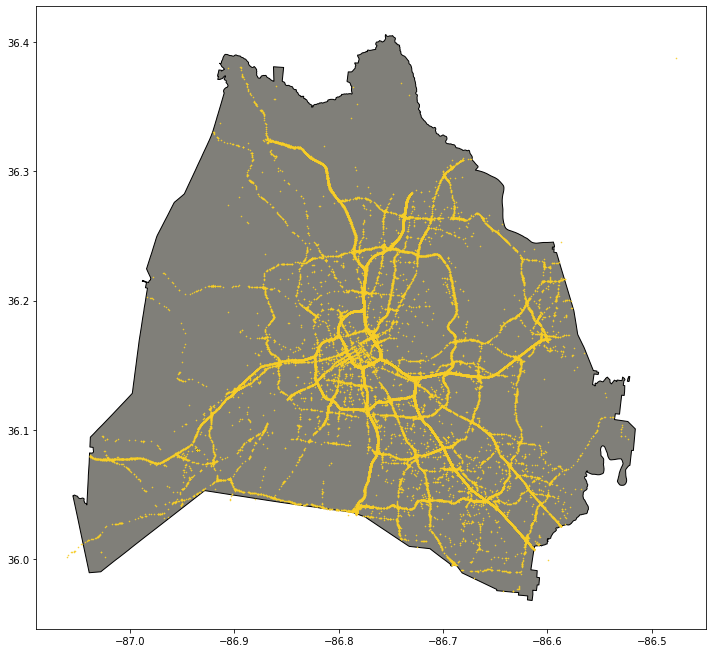

In [33]:
dax = gdf_david.plot(figsize=(12, 12), color = '#807f79',  edgecolor='black')
# .plot(ax = dax, color = '#807f79', edgecolor='black')
rdf2.plot(ax = dax, color='#f7ce28', markersize = 0.3)

## accidents for Feb 2022

In [ ]:
rdf_feb = rdf2[rdf2['ts_cst']>=1643695200]

<AxesSubplot:>

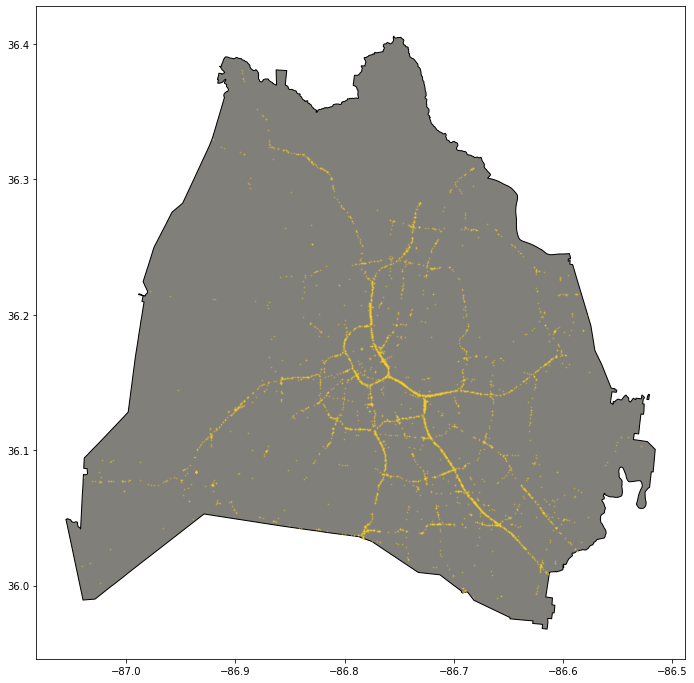

In [32]:
dax = gdf_david.plot(figsize=(12, 12), color = '#807f79',  edgecolor='black')
# .plot(ax = dax, color = '#807f79', edgecolor='black')
rdf_feb.plot(ax = dax, color='#f7ce28', markersize = 1, alpha = 0.3)

In [64]:
gdf_county = gpd.read_file("county.zip")
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]
gdf_david = gdf_dav.to_crs("EPSG:4326")
# gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# lotting grids over Davidson county - we ended up not using the grids

In [50]:
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds

array([1656664.95403244,  595562.71399883, 1816136.87059501,
        755249.86127501])

In [52]:
# gdf_dav.crs

In [53]:
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
# print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
# print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
# grid.to_file("grid.shp")
# grid.plot()

In [72]:
grids = grid.set_crs("EPSG:2274")

In [73]:
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')

In [187]:
dav_grids['grid_num'] = np.arange(len(dav_grids))
dav_grids2 = dav_grids.to_crs("EPSG:4326")
dav_grids2

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry,grid_num
0,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.03625 35.98958, -87.03922 35.989...",0
1,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04042 35.99398, -87.04103 35.996...",1
2,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04422 36.00845, -87.04592 36.014...",2
3,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04800 36.02293, -87.04958 36.029...",3
4,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.05177 36.03740, -87.05207 36.038...",4
...,...,...,...,...,...,...,...,...,...
599,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.53749 36.13664, -86.53578 36.138...",599
600,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((-86.52168 36.13739, -86.52341 36.137...",600
601,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51759 36.08439, -86.51764 36.083...",601
602,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51595 36.09890, -86.51678 36.091...",602


In [188]:
dav_grids2 = dav_grids2[['grid_num', 'geometry']].reset_index(drop=True)
# dav_grids2.to_csv('dav_grids.csv')

In [193]:
with open('dav_grids.geojson' , 'w') as file:
    file.write(dav_grids2.to_json())

In [231]:
joined_grids = gpd.sjoin(rdf2, dav_grids2, how='left').reset_index()
joined_grids = joined_grids[['grid_num', 'geometry', 'ts_cst', 'dt', 'dt_UTC', 'lat', 'lon', 'type']]

In [232]:
joined_grids = joined_grids.sort_values(['ts_cst'])

In [233]:
joined_grids

,grid_num,geometry,ts_cst,dt,dt_UTC,lat,lon,type
0,252.0,POINT (-86.80638 36.17019),1555934818,2019-04-22 07:06:58-05:00,2019-04-22 12:06:58 UTC,36.170188,-86.80638,ACCIDENT
6,380.0,POINT (-86.72099 36.10888),1555936781,2019-04-22 07:39:41-05:00,2019-04-22 12:39:41 UTC,36.108882,-86.720991,ACCIDENT
10,326.0,POINT (-86.76592 36.16851),1555954865,2019-04-22 12:41:05-05:00,2019-04-22 17:41:05 UTC,36.168511,-86.765922,ACCIDENT
14,181.0,POINT (-86.86410 36.18459),1555962172,2019-04-22 14:42:52-05:00,2019-04-22 19:42:52 UTC,36.184589,-86.864102,ACCIDENT
27,354.0,POINT (-86.74853 36.15000),1555968111,2019-04-22 16:21:51-05:00,2019-04-22 21:21:51 UTC,36.15,-86.748532,ACCIDENT
...,...,...,...,...,...,...,...,...
54000,331.0,POINT (-86.75877 36.23237),1646605192,2022-03-06 16:19:52-06:00,2022-03-06 22:19:52 UTC,36.232374,-86.758768,ACCIDENT
1175,360.0,POINT (-86.74751 36.23234),1646605192,2022-03-06 16:19:52-06:00,2019-06-07 20:47:10 UTC,36.232338,-86.747511,ACCIDENT
3789,302.0,POINT (-86.77665 36.19978),1646605192,2022-03-06 16:19:52-06:00,2019-08-26 13:59:57 UTC,36.199783,-86.776648,ACCIDENT
33175,271.0,POINT (-86.80207 36.11941),1646606385,2022-03-06 16:39:45-06:00,2021-04-28 22:00:04 UTC,36.119411,-86.802072,ACCIDENT


In [234]:
joined_grids.to_csv('accidents_nashville.csv', index=False)